# Analysis of GitHub Issues by User and by Label

This is an analysis of GitHub issues by user and by label to get an overview of the level of activity of the community contributions to Mondo and the diversity of the requests based on the issue labels. 

The plots include:
- Created and Closed GitHub issues since a given date (the date can be changed in the cell).
- Unique users who create issues each month
- Word cloud of issue labels. Note, some filtering and normalization of labels is done. See the code for details.

In [1]:
# Imports

#!pip install matplotlib wordcloud requests

import requests
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

In [2]:
# Get the data from GitHub

excluded_users = {"twhetzel", "nicolevasilevsky", "cmungall", "hrshdhgd", "sabrinatoro", "mellybelly", "matentzn", "joeflack4"}
# NOTE: Do not filter any "closed" counts by this excluded list since the Mondo team above closes tickets

headers = {
    "Accept": "application/vnd.github+json",
    "Authorization": f"Bearer {os.getenv('GITHUB_TOKEN')}"
}

def fetch_issues(repo, since):
    url = f"https://api.github.com/repos/{repo}/issues"
    issues = []
    page = 1
    while True:
        params = {
            "state": "all",
            "since": since,
            "per_page": 100,
            "page": page
        }
        # Get GitHub events
        res = requests.get(url, headers=headers, params=params)
        data = res.json()
        if not data:
            break
        issues.extend([i for i in data if 'pull_request' not in i])
        page += 1

    # Filter for only issues actually created in or after "since" date
    issues = [i for i in issues if i.get("created_at") and i["created_at"] >= since]
    
    return issues

repo = "monarch-initiative/mondo"
since = "2017-01-01T00:00:00Z"
issues = fetch_issues(repo, since)

# Prepare data
created_dates_by_month = [
    datetime.strptime(i["created_at"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")
    for i in issues if i.get("created_at") and i.get("user") and i["user"]["login"] not in excluded_users
]

closed_dates_by_month = [
    datetime.strptime(i["closed_at"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m")
    for i in issues if i.get("closed_at") and i.get("closed_by") and i["closed_by"]["login"]
]

created_years = [
    datetime.strptime(i["created_at"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y")
    for i in issues if i.get("created_at") and i.get("user") and i["user"]["login"] not in excluded_users
]

users_created_by_month = [
    (i["user"]["login"], datetime.strptime(i["created_at"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m"))
    for i in issues if i.get("user") and i["user"]["login"] not in excluded_users and i.get("created_at")
]

users_closed_by_month = [
    (i["closed_by"]["login"], datetime.strptime(i["closed_at"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y-%m"))
    for i in issues if i.get("closed_by") and i["closed_by"]["login"] and i.get("closed_at")
]

users_created_by_year = [
    (i["user"]["login"], datetime.strptime(i["created_at"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y"))
    for i in issues if i.get("user") and i.get("created_at") and i["user"]["login"] not in excluded_users
]

users_closed_by_year = [
    (i["closed_by"]["login"], datetime.strptime(i["closed_at"], "%Y-%m-%dT%H:%M:%SZ").strftime("%Y"))
    for i in issues if i.get("closed_by") and i.get("closed_at") and i["closed_by"]["login"]
]



In [3]:
# Save "issues" extracted from GitHub to be able to analyze the raw data in different ways and in Excel/Google Sheets as needed

import csv

with open("mondo_github_issues.tsv", "w", newline='', encoding='utf-8') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(["number", "title", "state", "created_at", "closed_at", "user"])
    for i in issues:
        writer.writerow([
            i["number"],
            i["title"],
            i["state"],
            i.get("created_at", ""),
            i.get("closed_at", ""),
            i["user"]["login"]
        ])


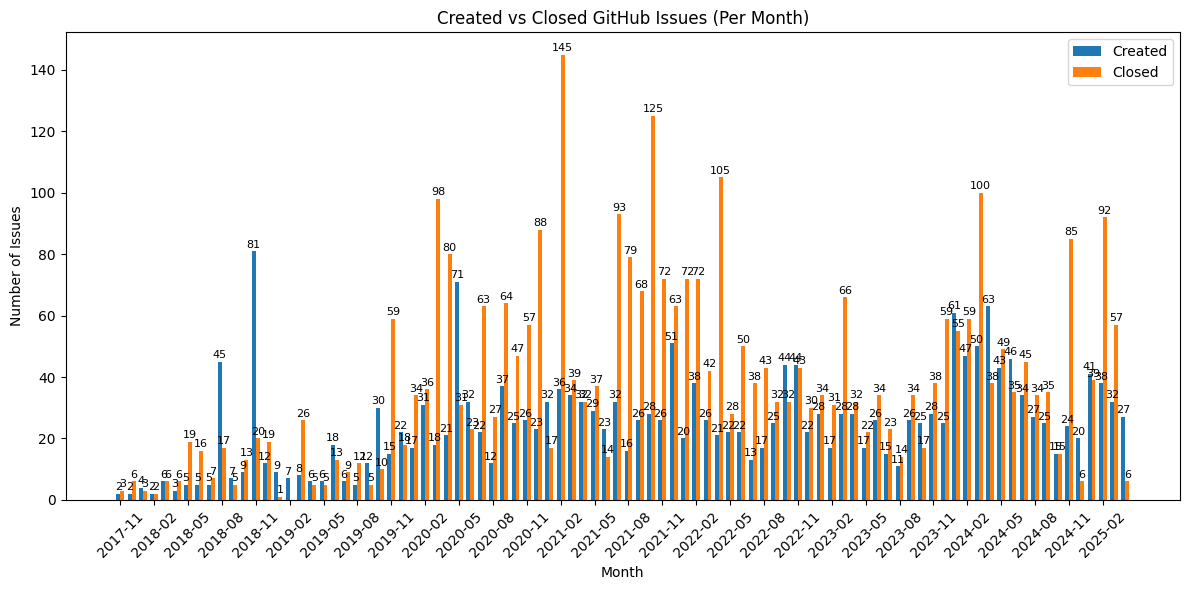

In [4]:
# Example GitHub UI filters
# is:issue created:2024-03-01..2024-03-30  
# is:issue closed:2024-03-01..2024-03-30  

# Bar chart: Created vs Closed issues per month

# Count
created_counter = Counter(created_dates_by_month)
closed_counter = Counter(closed_dates_by_month)

months = sorted(set(created_dates_by_month + closed_dates_by_month))
created_vals = [created_counter.get(m, 0) for m in months]
closed_vals = [closed_counter.get(m, 0) for m in months]

x = np.arange(len(months))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(12, 6))

bars1 = plt.bar(x - width/2, created_vals, width, label='Created')
bars2 = plt.bar(x + width/2, closed_vals, width, label='Closed')

# Only display count labels as needed
# Label the tops of the bars
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height), ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height), ha='center', va='bottom', fontsize=8)


plt.xlabel('Month')
plt.ylabel('Number of Issues')
plt.title('Created vs Closed GitHub Issues (Per Month)')
#plt.xticks(x, months, rotation=45)
plt.xticks(x[::3], months[::3], rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig("gh_issues_trend_bar.png")
plt.show()



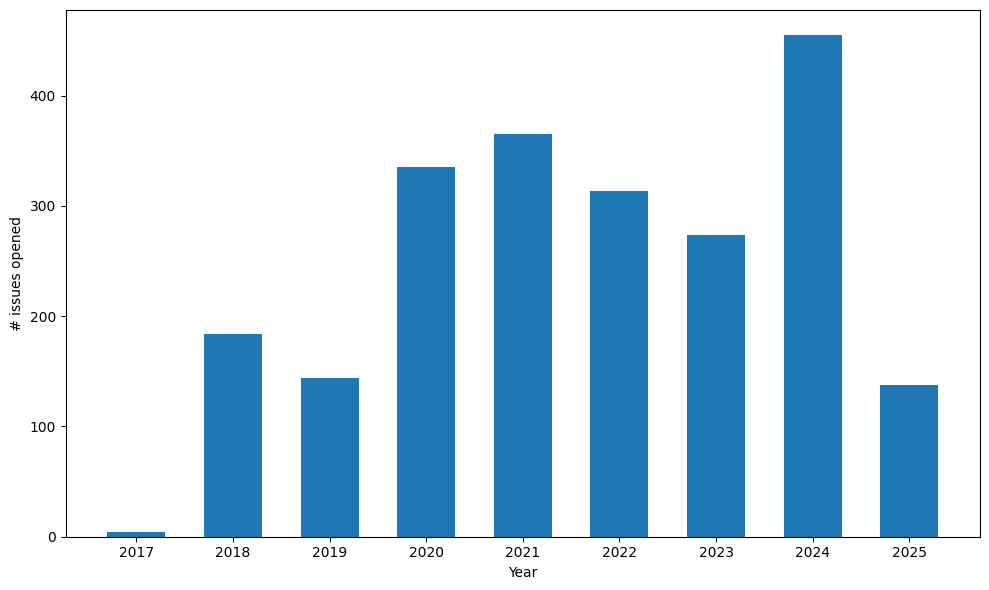

In [5]:
# Bar chart: Created issues per YEAR excluding Mondo team!!!

year_counter = Counter(created_years)
years = sorted(year_counter.keys())
x = np.arange(len(years))
values = [year_counter[y] for y in years]

plt.figure(figsize=(10, 6))
bars = plt.bar(x, values, width=0.6, label='Created')

# # Optional
# for bar in bars:
#     height = bar.get_height()
#     if height > 0:
#         plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
#                  ha='center', va='bottom', fontsize=9)

plt.xlabel('Year')
plt.ylabel('# issues opened')
#plt.title('Mondo Issues Created by Year')
plt.xticks(x, years)
#plt.legend()
plt.tight_layout()


plt.savefig("gh_issues_trend_bar-by_year_by_external_users.png")
plt.show()



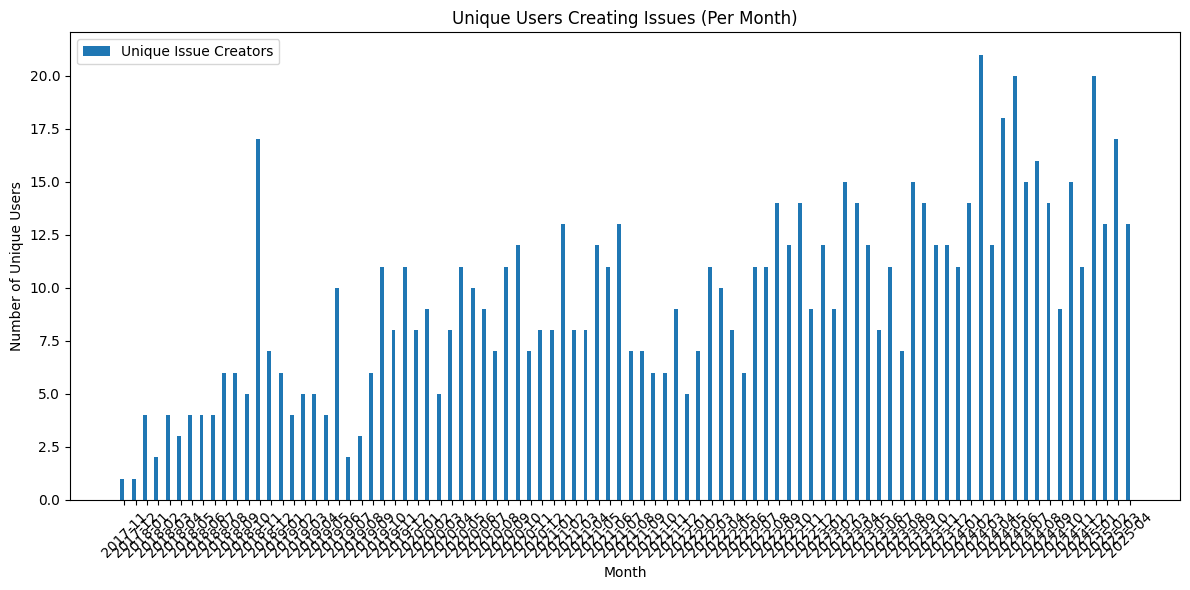

In [6]:
# Bar chart: Unique users creating and closing issues per month

# Unique users per month
df_created_users = pd.DataFrame(users_created_by_month, columns=["user", "month"])
df_closed_users = pd.DataFrame(users_closed_by_month, columns=["user", "month"])
unique_created = df_created_users.groupby("month")["user"].nunique()
unique_closed = df_closed_users.groupby("month")["user"].nunique()

months_users = sorted(set(unique_created.index).union(set(unique_closed.index)))
created_user_vals = [unique_created.get(m, 0) for m in months_users]
closed_user_vals = [unique_closed.get(m, 0) for m in months_users]

x = np.arange(len(months_users))
width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, created_user_vals, width, label='Unique Issue Creators')
#bars2 = plt.bar(x + width/2, closed_user_vals, width, label='Unique Closers', color='orchid')

# Only display count labels as needed
# Add labels above bars
# for bar in bars1:
#     height = bar.get_height()
#     if height > 0:
#         plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(height), ha='center', va='bottom', fontsize=8)

# No need to show unique users who close tickets since that is generally a member of the Mondo team
# for bar in bars2:
#     height = bar.get_height()
#     if height > 0:
#         plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(height), ha='center', va='bottom', fontsize=8)

plt.xlabel('Month')
plt.ylabel('Number of Unique Users')
plt.title('Unique Users Creating Issues (Per Month)')
plt.xticks(x, months_users, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig("gh_issues_users_per_month_bar.png")
plt.show()



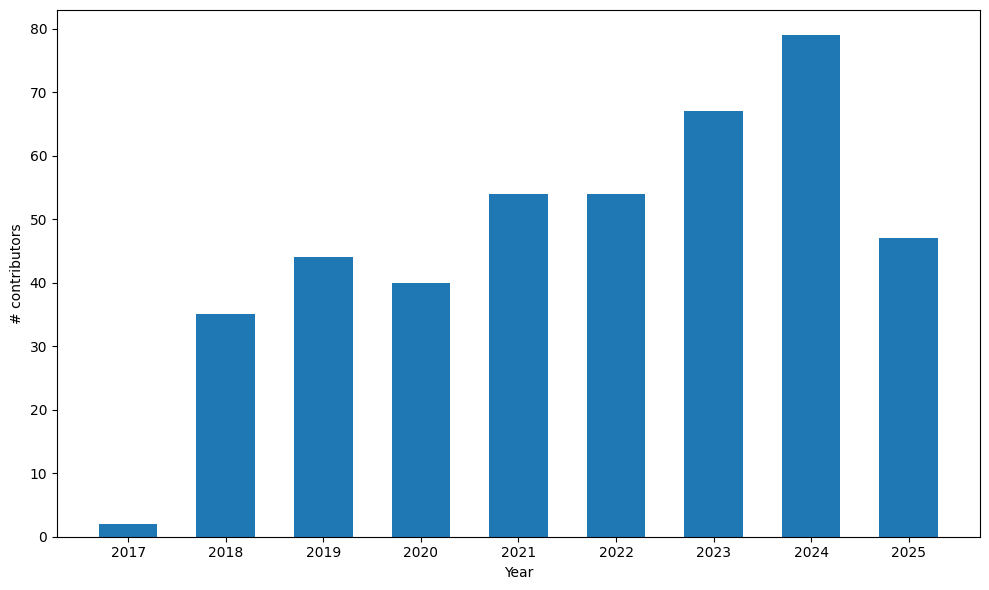

In [7]:
# Bar chart: Unique users creating (and closing) issues per YEAR excluding Mondo team!!!

# Unique users per YEAR
df_created_users = pd.DataFrame(users_created_by_year, columns=["user", "year"])
df_closed_users = pd.DataFrame(users_closed_by_year, columns=["user", "year"])
unique_created = df_created_users.groupby("year")["user"].nunique()
unique_closed = df_closed_users.groupby("year")["user"].nunique()


years_users = sorted(set(unique_created.index).union(set(unique_closed.index)))
created_user_vals = [unique_created.get(y, 0) for y in years_users]
# closed_user_vals = [unique_closed.get(y, 0) for y in years_users]

x = np.arange(len(years_users))
width = 0.6

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, created_user_vals, width, label='Unique Issue Creators')

# # Optional: Label the bars
# for bar in bars1:
#     height = bar.get_height()
#     if height > 0:
#         plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(height),
#                  ha='center', va='bottom', fontsize=9)

plt.xlabel('Year')
plt.ylabel('# contributors')
#plt.title('Unique Users Creating Issues')
plt.xticks(x, years_users)
#plt.legend()
plt.tight_layout()

plt.savefig("gh_issues_users_per_year_bar_by_external_user.png")
plt.show()


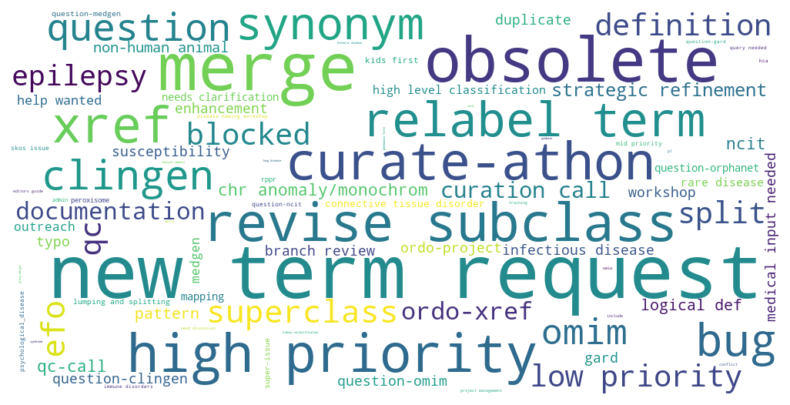

In [8]:
# Create a Word cloud of the issue labels 

label_counts = Counter()

# Filter out and normalize labels
for issue in issues:
    for label in issue["labels"]:
        label_name = label["name"].lower()

        # Remove unwanted labels for the Word cloud
        if "user request" == label_name: # Remove "user request" label since our focus is that these issues are user requests
            continue
        if "effort" in label_name:
            continue
        if "ada/peter" in label_name or "nicole/nico" in label_name:
            continue
        if "good first issue" in label_name or "tech" in label_name or "on list" in label_name or "website" in label_name:
            continue

        # Normalize labels
        if "curate" in label_name:
            label_name = "curate-athon"
        elif label_name == "mass obsoletion":
            label_name = "strategic refinement"

        label_counts[label_name] += 1


wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(label_counts)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.title("Issue Label Word Cloud")


plt.savefig("gh_issues_label_wordcloud.png")
plt.show()